In [ ]:


import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Computer_Vision/CelebA-HQ-img-20000.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA-HQ-img-20000/3316.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._3316.jpg  
  inflating: CelebA-HQ-img-20000/4479.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._4479.jpg  
  inflating: CelebA-HQ-img-20000/21792.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._21792.jpg  
  inflating: CelebA-HQ-img-20000/15437.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._15437.jpg  
  inflating: CelebA-HQ-img-20000/8243.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._8243.jpg  
  inflating: CelebA-HQ-img-20000/7170.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._7170.jpg  
  inflating: CelebA-HQ-img-20000/24832.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._24832.jpg  
  inflating: CelebA-HQ-img-20000/12358.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._12358.jpg  
  inflating: CelebA-HQ-img-20000/1501.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._1501.jpg  
  inflating: CelebA-HQ-img-20000/13046.jpg  
  inf

In [ ]:
!unzip /content/drive/MyDrive/Computer_Vision/CelebA-HQ-mask-20000.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA-HQ-mask-20000/13247_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._13247_hair.png  
  inflating: CelebA-HQ-mask-20000/14386_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._14386_hair.png  
  inflating: CelebA-HQ-mask-20000/14083_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._14083_hair.png  
  inflating: CelebA-HQ-mask-20000/04926_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._04926_hair.png  
  inflating: CelebA-HQ-mask-20000/01716_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._01716_hair.png  
  inflating: CelebA-HQ-mask-20000/25548_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._25548_hair.png  
  inflating: CelebA-HQ-mask-20000/13324_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._13324_hair.png  
  inflating: CelebA-HQ-mask-20000/22489_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._22489_hair.png  
  inflating: CelebA-HQ-mask-20000/06821_hair.

In [ ]:
def count_files(folder_path):
  """Counts the number of files in a folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  file_count = 0
  for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isfile(item_path):
      file_count += 1
  return file_count


In [ ]:
# Set Paths
IMAGE_DIR = "/content/CelebA-HQ-img-20000"
MASK_DIR = "/content/CelebA-HQ-mask-20000"

# Image and Mask Dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 2  # Number of segmentation classes (e.g., skin, hair, eyes, etc.)



In [ ]:
file_count = count_files(IMAGE_DIR)
print(f"Number of files in '{IMAGE_DIR}': {file_count}")

Number of files in '/content/CelebA-HQ-img-20000': 20001


In [ ]:
file_count = count_files(MASK_DIR)
print(f"Number of files in '{MASK_DIR}': {file_count}")

Number of files in '/content/CelebA-HQ-mask-20000': 20001


In [ ]:
# prompt: extract number from 0.jpg

import re

def extract_number(filename):
  """
  Extracts the number from a filename like "0.jpg".

  Args:
    filename: The filename string.

  Returns:
    The extracted number as an integer, or None if no number is found.
  """
  match = re.search(r"(\d+)", filename)
  if match:
    return int(match.group(1))
  return None

# Example usage
filename = "0.jpg"
number = extract_number(filename)
if number is not None:
    print(f"The number extracted from '{filename}' is: {number}")
else:
    print(f"No number found in '{filename}'")


The number extracted from '0.jpg' is: 0


In [ ]:
from tensorflow.keras.utils import to_categorical
# Modified load_data function to yield batches and handle potential errors
def load_data(image_dir, mask_dir, batch_size=32, test_data=False, test_size=0.2, random_state=42):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Split into train and test sets if requested
    if test_data:
      _, test_image_files, _, test_mask_files = train_test_split(
          image_files, mask_files, test_size=test_size, random_state=random_state
      )
      image_files = test_image_files
      mask_files = test_mask_files

    num_samples = len(image_files)

    for i in range(0, num_samples, batch_size):
        batch_images, batch_masks = [], []
        for j in range(i, min(i + batch_size, num_samples)):
            img_name = image_files[j]

            # Extract image number and construct mask filename
            filenumber = extract_number(img_name)
            image_number = str(filenumber).zfill(5)
            mask_name = image_number + "_hair.png"

            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f"Mask file not found for image: {image_number}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error reading mask: {mask_path}")
                continue
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            mask = (mask / 255 * (NUM_CLASSES - 1)).astype(np.uint8)
            mask = to_categorical(mask, NUM_CLASSES)

            batch_images.append(img)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)



In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(u5)
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(c7)

    return Model(inputs, outputs)

# Checkpoint to save the model with the best validation accuracy
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision/best_model_20000.h5' # Save in your drive
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',              # Save the model with the maximum validation accuracy
    save_best_only=True     # Save only the best model
)

# Compile U-Net model
model =  unet_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,697,410 (29.36 MB)

 Trainable params: 7,697,410 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

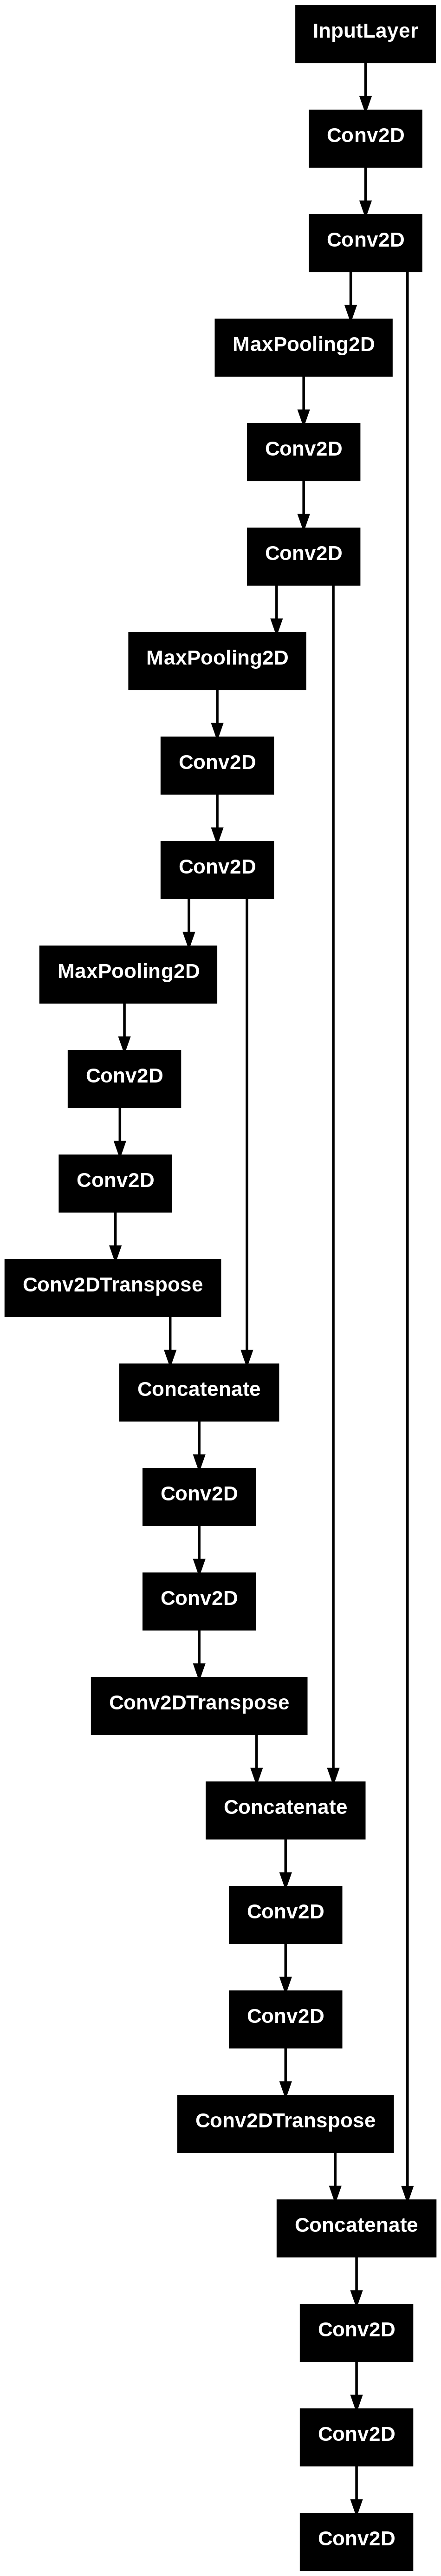

In [ ]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png')

In [ ]:
# Training with batches
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE),  # Use the generator
    steps_per_epoch=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE, # Number of batches per epoch
    validation_data=load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE), # Validation data generator
    validation_steps=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE // 5, # Validation steps
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7648 - loss: 0.4749

625/625 ━━━━━━━━━━━━━━━━━━━━ 945s 1s/step - accuracy: 0.7649 - loss: 0.4748 - val_accuracy: 0.9048 - val_loss: 0.2395
Epoch 2/10
  1/625 ━━━━━━━━━━━━━━━━━━━━ 2:26:51 14s/step - accuracy: 0.9691 - loss: 0.1076

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 104ms/step - accuracy: 0.9691 - loss: 0.1076 - val_accuracy: 0.8741 - val_loss: 0.3186
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 102ms/step - accuracy: 0.8789 - loss: 0.3033 - val_accuracy: 0.9005 - val_loss: 0.2538
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.8919 - loss: 0.2772 - val_accuracy: 0.8939 - val_loss: 0.2771
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 200ms/step - accuracy: 0.8923 - loss: 0.2712 - val_accuracy: 0.8941 - val_loss: 0.2688
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8901 - loss: 0.2652 - val_accuracy: 0.8947 - val_loss: 0.2533


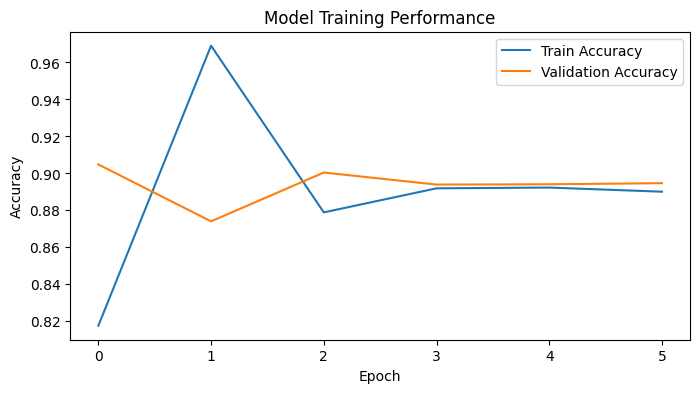

In [ ]:
# Plot Training History
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training Performance')
plt.show()
